<a href="https://colab.research.google.com/github/monouns/ESG-AI-investment/blob/master/Data_Creation/Data_for_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make Dataset with FinanceDataReader

In [1]:
!pip install finance-datareader --upgrade

     |████████████████████████████████| 48 kB 1.8 MB/s 


In [2]:
import FinanceDataReader as fdr
fdr.__version__

'0.9.33'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [46]:
import numpy as np
import pandas as pd
import re
from itertools import product
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

In [5]:
def get_russell_companies(n=100, sector=None):
    """
    Get the top n Russell 1000 companies from
    https://www.ishares.com/us/products/239707/ishares-russell-1000-etf
    Companies that have multiple classes of stock (e.g. Series A, Series C)
    are collapsed into one company name.
    """
    def rm_class(s):
        """ Remove the class, series, etc. from a stock. """
        class_types = ["CLASS", "SERIES", "REIT", "SHS"]
        share_class = [" ".join(x) + r"( |$)" for x in product(class_types,
                       ["A", "B", "C", "I"])]
        for sc in share_class:
          s = re.sub(sc, "", s).strip()
        return s

    # Download and parse the Russell 1000 companies
    url = ("https://www.ishares.com/us/products/239707/ishares-russell-1000-etf/"
           "1467271812596.ajax?fileType=csv&fileName=IWB_holdings&dataType=fund")
    russell_1000 = pd.read_csv(url, skiprows=range(9), header=0,
                               usecols=["Ticker", "Name"])
    russell_1000["Name"] = russell_1000.Name.astype(str).apply(rm_class)
    russell_1000.drop_duplicates(inplace=True)

    return russell_1000.iloc[:n].Ticker.to_list(), russell_1000.iloc[:n].Name.to_list()

def make_aliases(c):
    """
    Make a list of aliases for a given company using a few predefined
    rules. Try to encompass as many options as possible keeping in mind
    there will be aliases left out.
    """
    c = c.lower()

    # URLs (e.g. ".com")
    if len(c) > 3 and c[-4] == ".":
        c = c.rsplit(".", 1)[0].replace(".", " ")

    # Single letter endings
    if len(c.split()[-1]) == 1:
        c = c.rsplit(" ", 1)[0]

    # Company legal endings
    endings = ["inc", "corp", "plc", "reit", "co", "cor", "group", "company",
               "trust", "energy", "international", "of america", "pharmaceuticals",
               "clas", "in", "nv", "sa", "re"]
    n_endings = 3  # Can have up to 3 of these endings
    for _ in range(n_endings):
        c = c.rsplit(" ", 1)[0] if any([c.endswith(" " + e) for e in endings]) else c

    c = c.replace("-", " ")

    return c

def get_company_alias_dict(n=100, sector=None):
    """
    Download the companies and loop through them to find their aliases
    """
    ticker, companies = get_russell_companies(n, sector)

    comp = []
    for c in companies:
        comp.append(make_aliases(c))
    
    return ticker, comp

In [6]:
ticker, companies = get_company_alias_dict(n=300)

In [7]:
ticker = pd.Series(ticker).values
companies = pd.Series(companies).values

stock_df = pd.DataFrame(np.vstack([ticker, companies])).T
stock_df.columns = ['ticker', 'company']
stock_df.to_csv('./stock_list.csv', index=0)

In [6]:
#ticker index = 103 is not provided in fdr
datetime = ['2021-12-01', '2022-04-21']
data = pd.DataFrame() 
for code in tqdm(list(ticker)):
    df = pd.DataFrame()
    stock = fdr.DataReader(code, start = datetime[0], end = datetime[1])
    df[code] = stock['Close']

    df.reset_index(inplace=True, drop=True)

    data = pd.concat([data, df], axis=1)

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
data

In [9]:
data.to_csv('./data.csv', index=0)

In [ ]:
data.set_index('Date', inplace=True)
data = data.interpolate(method='linear', limit_direction='both')
data.columns = list(stock_df['company'].values[:103]) + list(stock_df['company'].values[104:])
data

In [29]:
data.to_csv('./data.csv')

# Efficient Frontiner from Modern Portfolio Theory implemented in Python (Markowitz Portfolio Theory)

In [42]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate, num_assets):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [43]:
num_assets = 8
table = data.copy().iloc[:, :num_assets]
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [44]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, num_assets):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate, num_assets)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.35
Annualised Volatility: 0.17


             apple  microsoft  amazon com  tesla  alphabet  alphabet  \
allocation  1062.0      217.0       327.0   68.0     186.0    1259.0   

            berkshire hathaway  unitedhealth  
allocation              5567.0        1314.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.35
Annualised Volatility: 0.17


             apple  microsoft  amazon com  tesla  alphabet  alphabet  \
allocation  1062.0      217.0       327.0   68.0     186.0    1259.0   

            berkshire hathaway  unitedhealth  
allocation              5567.0        1314.0  


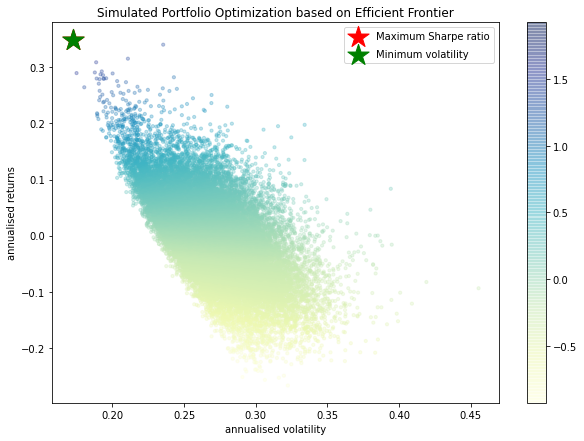

In [45]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, num_assets)

In [47]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [48]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, num_assets):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate, num_assets)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.58
Annualised Volatility: 0.16


            apple  microsoft  amazon com  tesla  alphabet  alphabet  \
allocation    0.0        0.0         0.0    0.0       0.0       0.0   

            berkshire hathaway  unitedhealth  
allocation                73.0          27.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.49
Annualised Volatility: 0.16


            apple  microsoft  amazon com  tesla  alphabet  alphabet  \
allocation   4.36       4.18        2.18    0.0       0.0       0.0   

            berkshire hathaway  unitedhealth  
allocation               61.12         28.17  


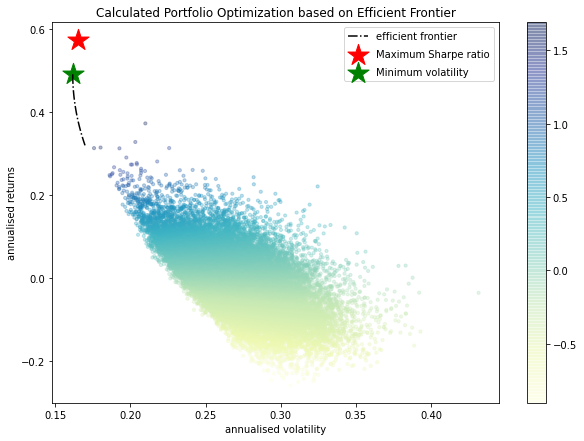

In [49]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, num_assets)

In [50]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.58
Annualised Volatility: 0.16


            apple  microsoft  amazon com  tesla  alphabet  alphabet  \
allocation    0.0        0.0         0.0    0.0       0.0       0.0   

            berkshire hathaway  unitedhealth  
allocation                73.0          27.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.49
Annualised Volatility: 0.16


            apple  microsoft  amazon com  tesla  alphabet  alphabet  \
allocation   4.36       4.18        2.18    0.0       0.0       0.0   

            berkshire hathaway  unitedhealth  
allocation               61.12         28.17  
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

apple : annuaised return 0.07 , annualised volatil

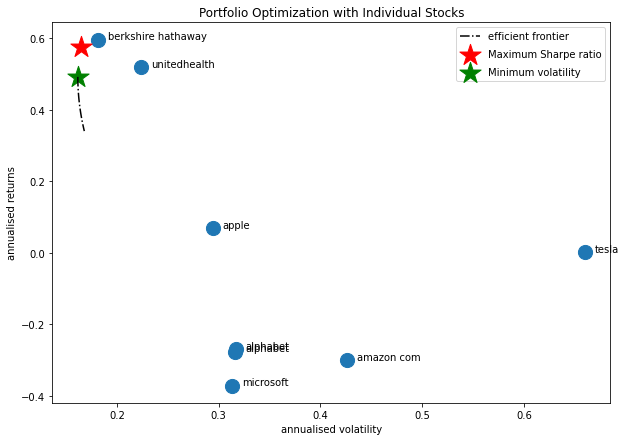

In [51]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)